# Light GBM

Use tree-based algorithms since they are powerful and do not impose strict assumptions on features like linearity or independence. Light GBM is a fast algorithm with lower memory usage.

In [1]:
!pip install lightgbm

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#conda install numpy

Import libraries

In [3]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from sagemaker import get_execution_role


Read data

In [4]:
X_train = pd.read_pickle('../01_preprocessed_data/X_train.pkl')
y_train = pd.read_pickle('../01_preprocessed_data/y_train.pkl')
X_val = pd.read_pickle('../01_preprocessed_data/X_val.pkl')
y_val = pd.read_pickle('../01_preprocessed_data/y_val.pkl')
X_test = pd.read_pickle('../01_preprocessed_data/X_test.pkl')



In [5]:
role = get_execution_role()
bucket='sagemaker-eu-central-1-594657351600'
prefix = 'kaggle-m5/00_data'

data_location = 's3://{}/{}/{}'.format(bucket, prefix, 'sample_submission.csv')
submission = pd.read_csv(data_location)


Set parameters of the light GBM and select features to fit.

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)


(42644016, 33)
(1706991, 33)
(853720, 33)
(42644016, 1)
(1706991, 1)


In [7]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}
not_features = ['id', 'items_sold', 'date', 'start_date', 'avg_month_demand', 'median_month_demand']

In [ ]:
categorical_features = ['weekday', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'forecastability']
#for c in categorical_features:
#    col_type = X_train[c].dtype
#    if col_type == 'object' or col_type.name == 'category':
#        X_train[c] = X_train[c].astype('category')
features = X_test.columns[~X_test.columns.isin(not_features)]


In [8]:
train_set = lgb.Dataset(X_train, y_train) #, categorical_feature = categorical_features)
val_set = lgb.Dataset(X_val[X_train.columns], y_val)#,  categorical_feature = categorical_features)

Train the model

In [9]:
model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)#, categorical_feature=categorical_features)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.69828	valid_1's rmse: 2.26448
[200]	training's rmse: 2.62219	valid_1's rmse: 2.24722
[300]	training's rmse: 2.57133	valid_1's rmse: 2.23466
[400]	training's rmse: 2.53381	valid_1's rmse: 2.23174
Early stopping, best iteration is:
[400]	training's rmse: 2.53381	valid_1's rmse: 2.23174


Calculate the RMSE on the validation set

In [10]:
val_pred = model.predict(X_val[X_train.columns])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
X_val['items_sold'] = y_val
X_val['items_pred'] = val_pred
X_val['abs_difference'] = abs(X_val['items_sold'] - X_val['items_pred'])
print(f'Our val rmse score is {val_score}')
y_test = model.predict(X_test[X_train.columns])
X_test['items_sold'] = y_test


Our val rmse score is 2.2317414255997425


In [11]:
val_pred

array([0.65566981, 0.22023475, 0.21656681, ..., 1.16958309, 1.4444396 ,
       2.5780506 ])

We look at the mean absolute error by forecastablity in order to indestand what category needs more improvement for prediction.

In [12]:
X_val.groupby(['forecastability'])['forecastability', 'abs_difference'].agg(['mean']).reset_index()

,forecastability,abs_difference
,,mean
0,erratic,3.528263
1,intermittent,0.707212
2,lumpy,1.579035
3,smooth,2.782239


Surprisingly smooth time series has a large mean absolute error. Erratic time series has a large mean absolute error; typically time series of this type is difficult to predict.

## Feature importance

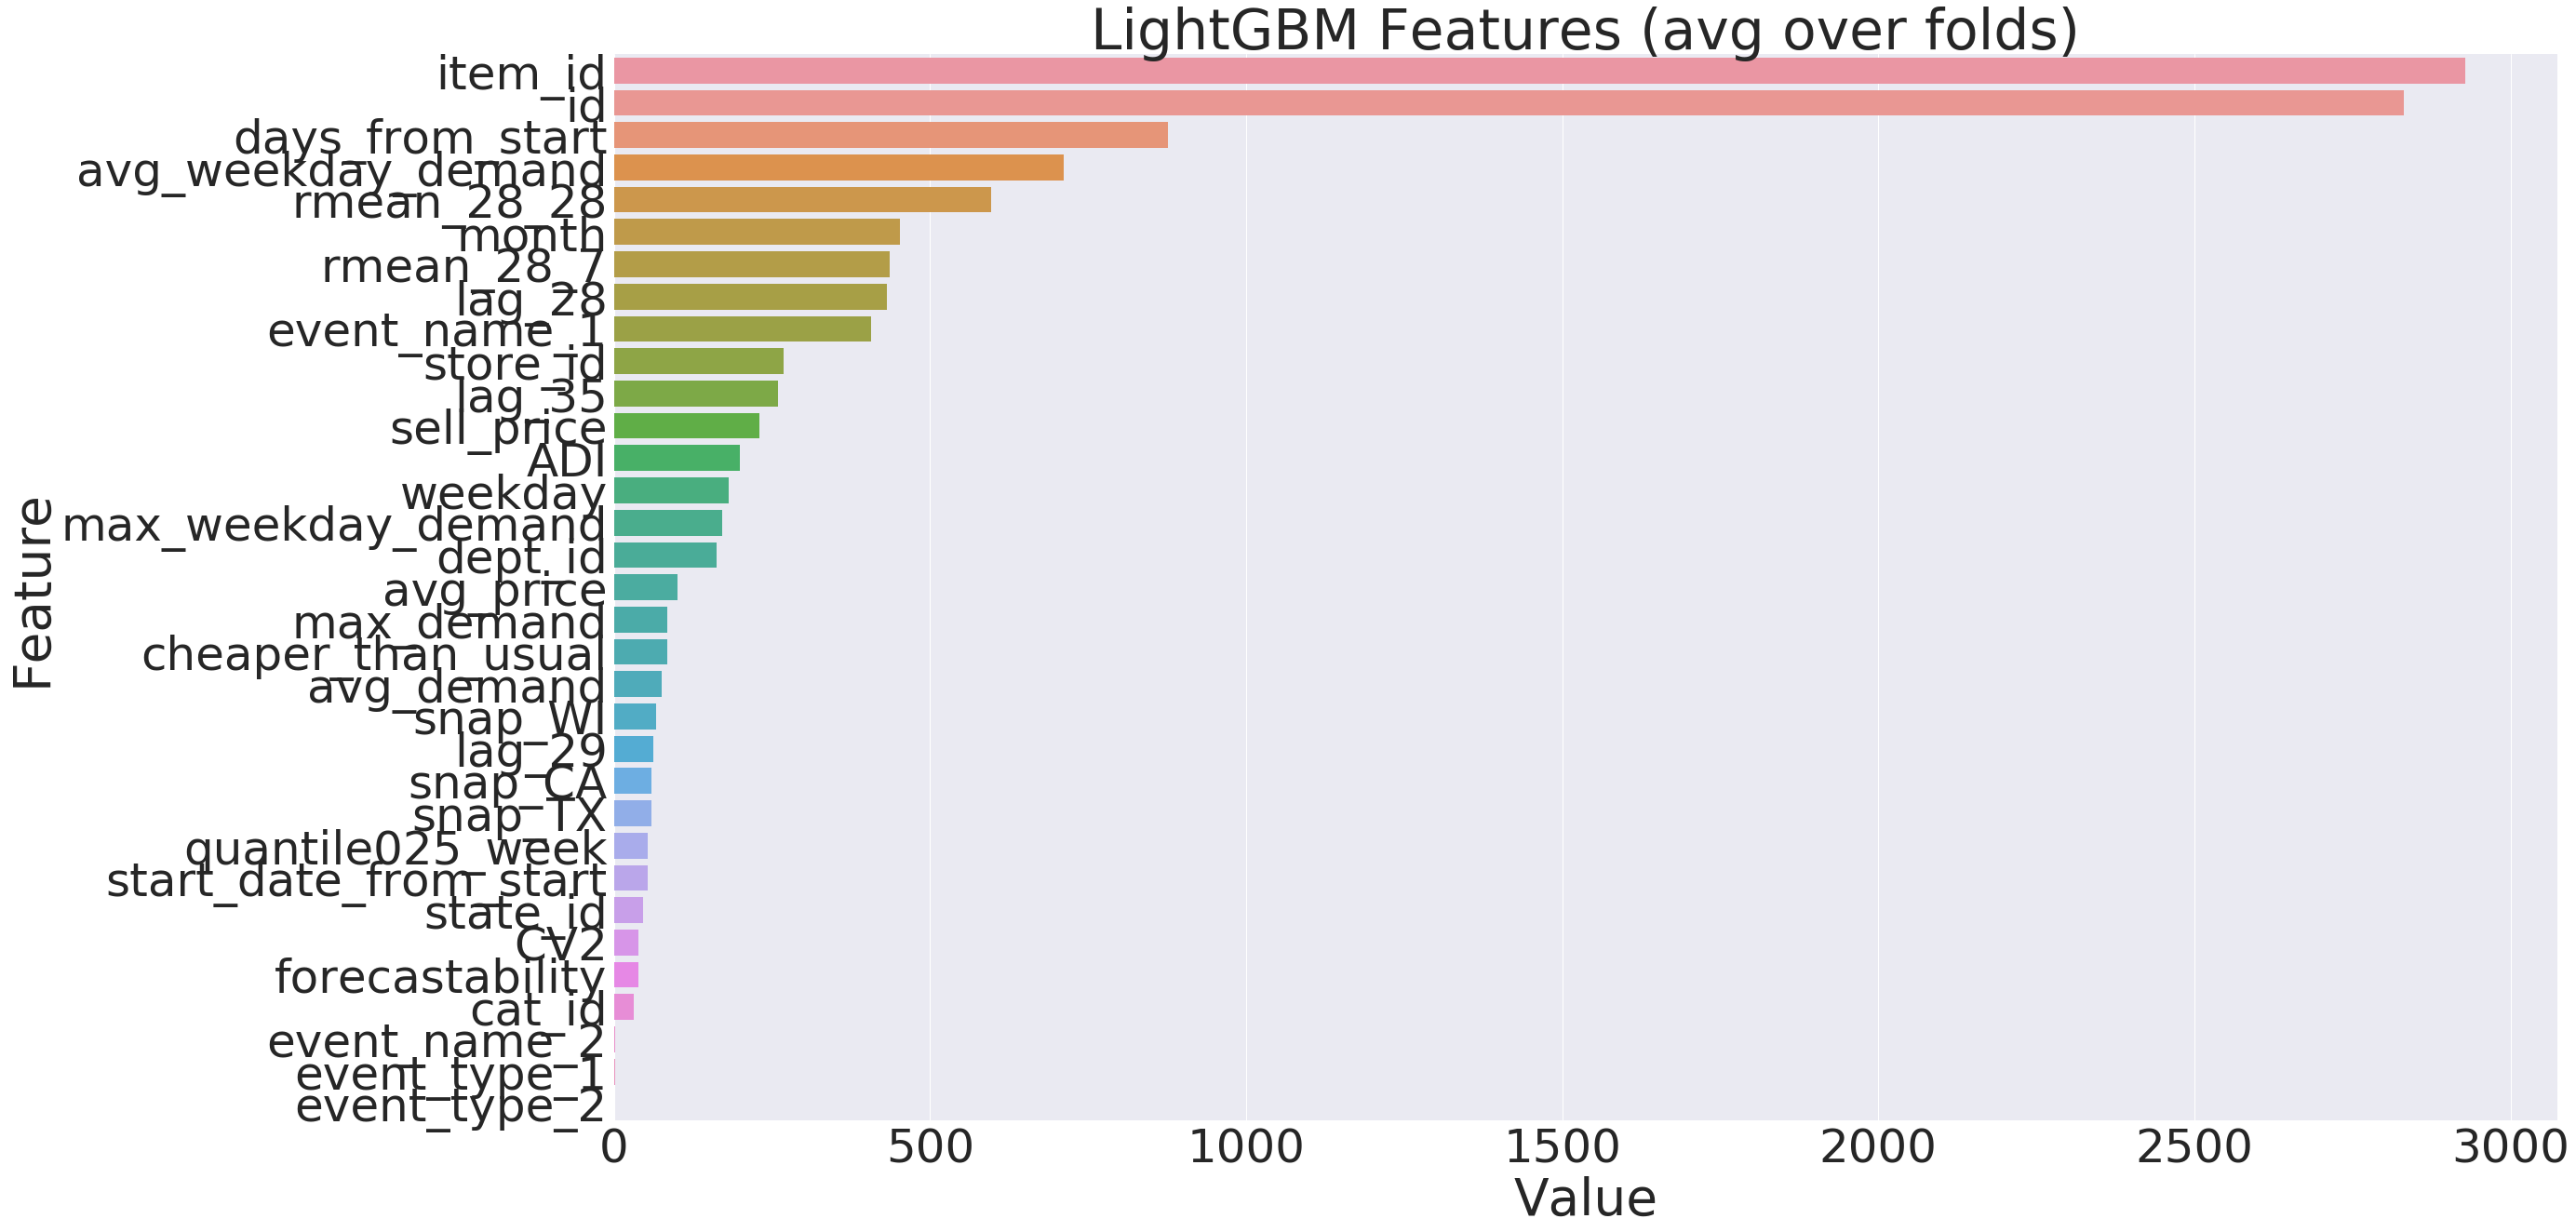

In [13]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train, 35)

'item_id' and 'id' are most important features. 'days_from_start' reflect the trend of data. 

## Transform prediction

Transform predictions to the right format

In [15]:
predictions = X_test[['id', 'days_from_start', 'items_sold']]
predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'items_sold').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.743167,0.788587,0.603166,0.589312,0.677044,0.934324,0.784741,0.627486,0.829775,...,0.760455,1.134839,0.876863,0.700792,0.815112,0.651631,0.704088,0.792928,1.097865,0.919557
1,HOBBIES_1_002_CA_1_validation,0.277563,0.273770,0.285215,0.317084,0.329458,0.412253,0.322525,0.215571,0.211554,...,0.239353,0.291788,0.256860,0.200209,0.200803,0.244193,0.262186,0.258445,0.300680,0.251065
2,HOBBIES_1_003_CA_1_validation,0.337710,0.355305,0.355305,0.383095,0.462695,0.434058,0.402507,0.284215,0.281201,...,0.486520,0.678717,0.540049,0.358268,0.394559,0.407442,0.438904,0.571763,0.769862,0.570577
3,HOBBIES_1_004_CA_1_validation,1.827081,1.516057,1.432371,1.582973,1.789368,2.636563,2.619361,1.518420,1.440420,...,1.817733,2.580106,3.303732,1.679753,1.462693,1.337445,1.533004,1.828385,3.319230,3.125820
4,HOBBIES_1_005_CA_1_validation,0.931623,0.815221,0.994971,1.123708,1.195732,1.632217,1.795428,1.198076,1.125775,...,1.202205,1.633978,1.603810,0.926597,0.876263,0.962685,1.002377,1.150917,1.692727,1.794715


Save the submission, the features and the score to files.

In [16]:
final.to_csv('../04_submissions/lightGBM_no_fe.csv', index = False)

In [17]:
features = X_test.columns[~X_test.columns.isin(not_features)]
features = features.to_list()
features.append(str(val_score))
features.append(str(params['objective']))


In [18]:
with open("../04_submissions/lgb_features_score.txt", "a") as outfile:
    outfile.write("\n".join(features))


## Score

The score of this submission is 0.58584, which is better than naive prediction.